In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from google.colab import drive
from google.colab import files
import sys
from PIL import Image

In [2]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [3]:

# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

def load_image_test(input_image, real_image):
    # real_image = tf.image.grayscale_to_rgb(real_image)
    #input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	return [X1, X2]

In [5]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/ImageToDEM/'
sys.path.append(path)
# load image data
dataset = load_real_samples(path + 'DataAll/Test.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
dataset[0] = tf.cast(dataset[0],tf.float32)
dataset[1] = tf.cast(dataset[1],tf.float32)

test_dataset = tf.data.Dataset.from_tensor_slices((dataset[0], dataset[1]))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded (16, 256, 256, 3) (16, 256, 256, 1)


In [6]:
def generate_images(model, test_input, total, tar=tf.zeros([0,0])):
  path = '/content/drive/My Drive/ImageToDEM/ncGAN/OUT'
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  pre = ['input', 'target', 'prediction']
  dirs = ['/inputs/', '/targets/', '/predictions/']
  plt.figure(figsize=(15,15))
  if(tf.size(tar) > 0):
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
  else:
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
  for i in range(len(title)):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    if(display_list[i].shape[2] == 1):
      plt.imshow(display_list[i][:, :, 0]*0.5 + 0.5, cmap='gray')
      plt.imsave(path + dirs[i] + pre[i] + str(total) + ".png", display_list[i][:, :, 0]*0.5 + 0.5, cmap='gray')

    else:
      dl = display_list[i]*0.5 + 0.5
      dl = np.array(dl)#, dtype=np.uint8)
      dl = np.array(255*dl, dtype=np.uint8)
      plt.imshow(dl)
      plt.imsave(path + dirs[i] + pre[i] + str(total) +".png", dl) 

    plt.axis('off')
  plt.show()
  if(not tf.size(tar) > 0):
    return prediction 

In [7]:
generator = tf.saved_model.load('/content/drive/My Drive/ImageToDEM/ncGAN/models')
# Run the trained model on the entire test dataset


In [9]:
if not os.path.isdir('/content/drive/My Drive/ImageToDEM/ncGAN/OUT'):
  os.mkdir('/content/drive/My Drive/ImageToDEM/ncGAN/OUT')
if not os.path.isdir('/content/drive/My Drive/ImageToDEM/ncGAN/OUT/inputs'):
  os.mkdir('/content/drive/My Drive/ImageToDEM/ncGAN/OUT/inputs')
if not os.path.isdir('/content/drive/My Drive/ImageToDEM/ncGAN/OUT/targets'):
  os.mkdir('/content/drive/My Drive/ImageToDEM/ncGAN/OUT/targets')
if not os.path.isdir('/content/drive/My Drive/ImageToDEM/ncGAN/OUT/predictions'):
  os.mkdir('/content/drive/My Drive/ImageToDEM/ncGAN/OUT/predictions')

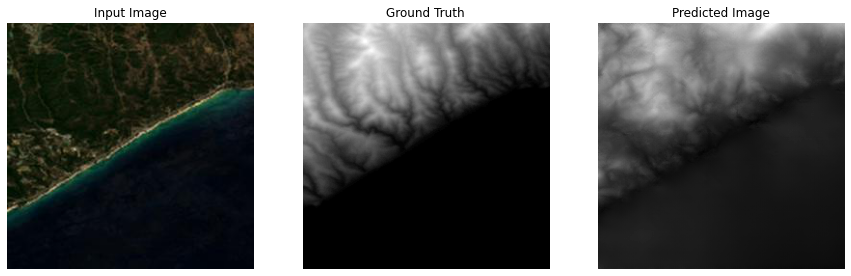

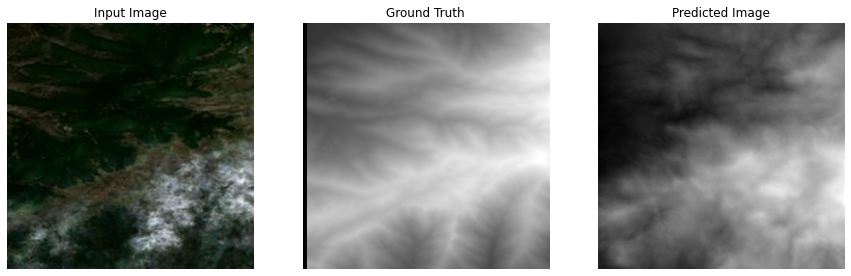

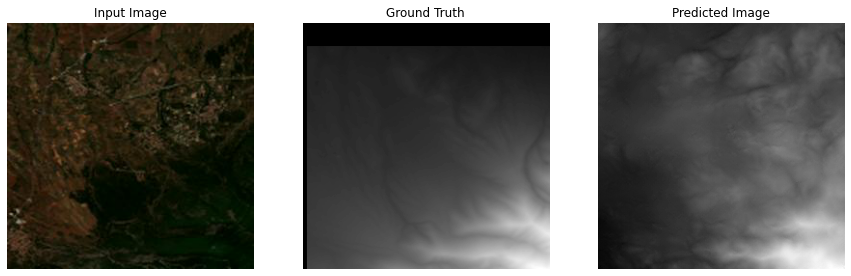

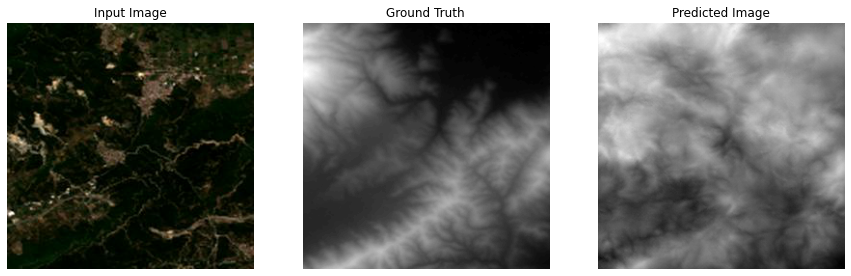

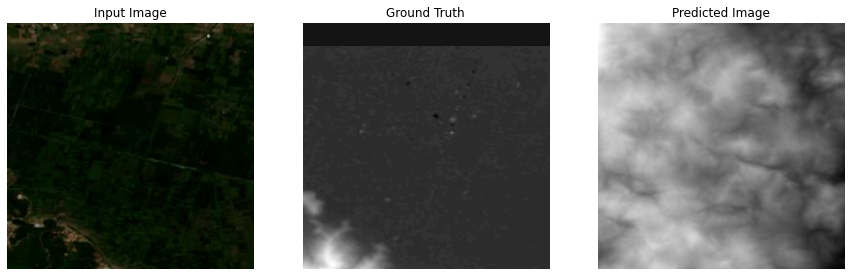

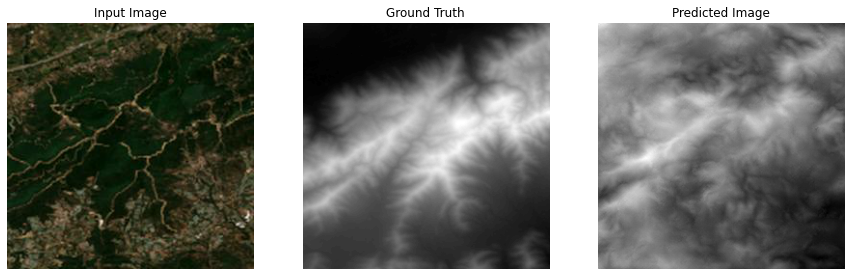

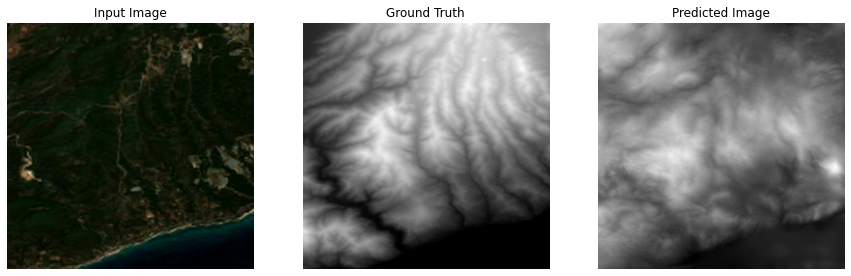

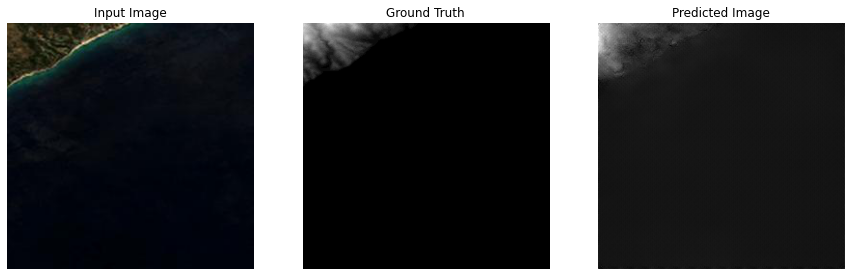

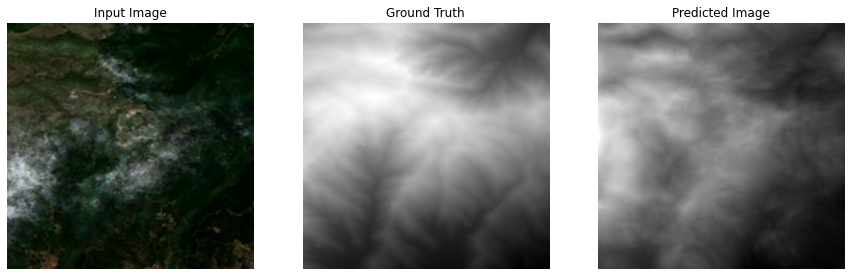

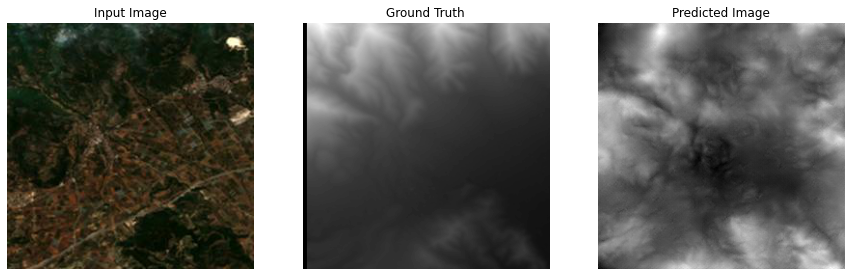

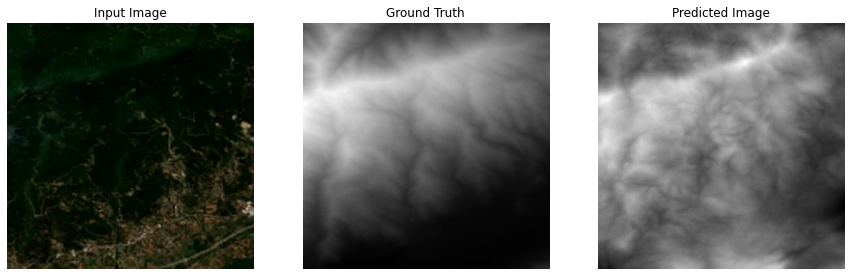

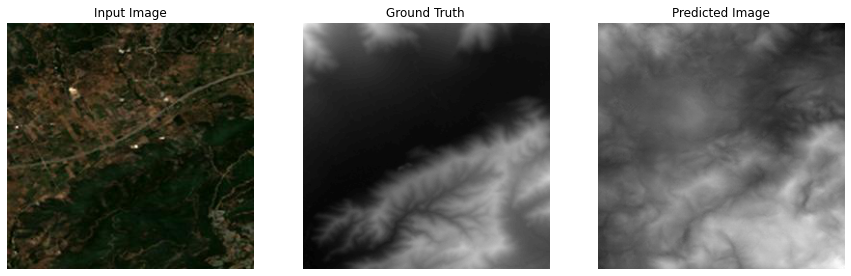

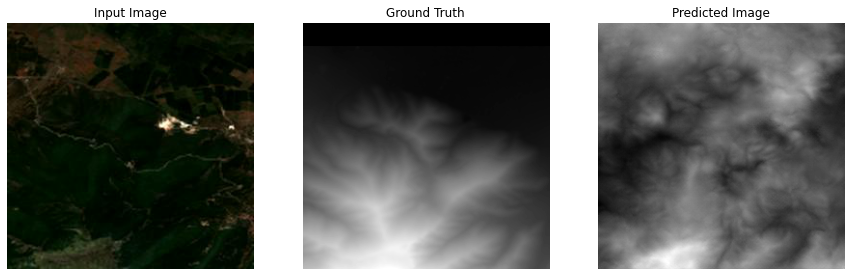

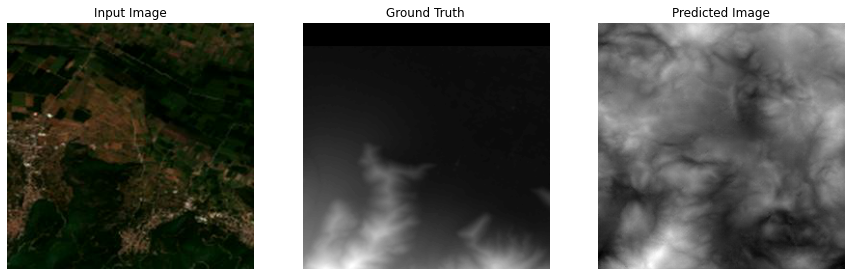

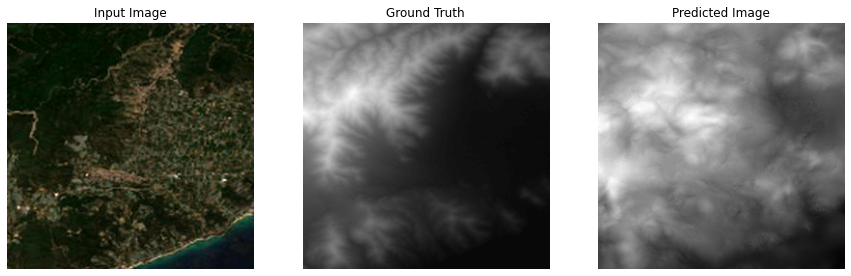

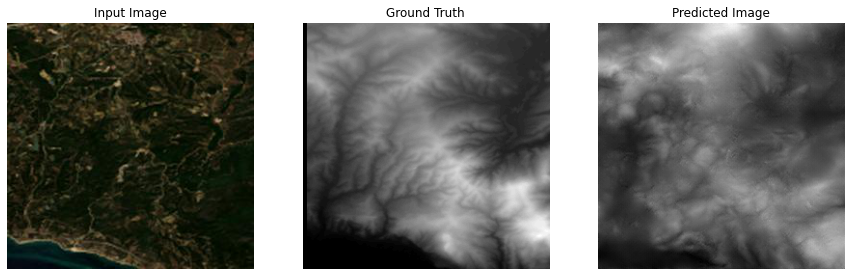

In [10]:
tot = 0
for inp, tar in test_dataset:
  generate_images(generator, inp, tot, tar)
  tot += 1